In [22]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

In [23]:
# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
my_region = boto3.session.Session().region_name # set the region of the instance

In [49]:
# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")
print("Success - the MySageMakerInstance is in the " + my_region + " region.")

Success - the MySageMakerInstance is in the us-west-2 region.


In [25]:
model_data = pd.read_csv('DEMO.csv')
model_data.head()

,time,DO,NH4,NO3,N2O,prediction
0,2018-06-08T00:00:00.000Z,0.308,6.984,2.462,0.48,0.499747
1,2018-06-08T00:15:00.000Z,0.298,7.565,2.623,0.45,0.499747
2,2018-06-08T00:30:00.000Z,0.210,7.487,2.615,0.46,0.499747
3,2018-06-08T00:45:00.000Z,0.205,7.902,2.762,0.51,0.499747
4,2018-06-08T01:00:00.000Z,0.347,7.829,2.762,0.47,0.499747


In [26]:
#prepare the data
model_data.drop('prediction', inplace=True, axis=1)
model_data.head()

,time,DO,NH4,NO3,N2O
0,2018-06-08T00:00:00.000Z,0.308,6.984,2.462,0.48
1,2018-06-08T00:15:00.000Z,0.298,7.565,2.623,0.45
2,2018-06-08T00:30:00.000Z,0.210,7.487,2.615,0.46
3,2018-06-08T00:45:00.000Z,0.205,7.902,2.762,0.51
4,2018-06-08T01:00:00.000Z,0.347,7.829,2.762,0.47


In [27]:
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(453, 5) (195, 5)


In [28]:
bucket_name = 'bnvina-sagemaker-us-west-2' 

# Model - 1
### without time field

In [35]:
pd.concat([model_data['N2O'], model_data.drop(['time', 'N2O'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [36]:
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(xgboost_container,role, instance_count=1, instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',num_round=100)

In [37]:
xgb.fit({'train': s3_input_train})

2021-07-05 11:06:36 Starting - Starting the training job...
2021-07-05 11:06:59 Starting - Launching requested ML instancesProfilerReport-1625483196: InProgress
...
2021-07-05 11:07:30 Starting - Preparing the instances for training.........
2021-07-05 11:09:00 Downloading - Downloading input data......
2021-07-05 11:10:00 Training - Downloading the training image.Arguments: train
[2021-07-05:11:10:10:INFO] Running standalone xgboost training.
[2021-07-05:11:10:10:INFO] Path /opt/ml/input/data/validation does not exist!
[2021-07-05:11:10:10:INFO] File size need to be processed in the node: 0.03mb. Available memory size in the node: 8415.68mb
[2021-07-05:11:10:10:INFO] Determined delimiter of CSV input is ','
[11:10:10] S3DistributionType set as FullyReplicated
[11:10:10] 648x4 matrix with 2592 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[11:10:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 12 pruned nodes, max_depth=2


In [38]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

-------------!

In [39]:
from sagemaker.serializers import CSVSerializer


In [40]:
model_data_array = model_data.drop(['time','N2O'], axis=1).values #load the data into an array
xgb_predictor.serializer = CSVSerializer() # set the serializer type
predictions2 = xgb_predictor.predict(model_data_array).decode('utf-8') # predict!
predictions2_array = np.fromstring(predictions2[1:], sep=',') # and turn the prediction into an array
print(predictions2_array.shape)

(648,)


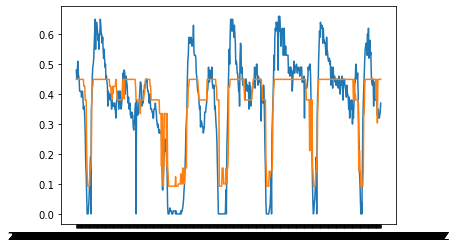

In [41]:
fig2, ax2 = plt.subplots()
ax2.plot(model_data['time'], model_data['N2O'], predictions2_array)
plt.show()

In [42]:
processed_data = model_data
processed_data['prediction'] = predictions2_array
processed_data.head()

,time,DO,NH4,NO3,N2O,prediction
0,2018-06-08T00:00:00.000Z,0.308,6.984,2.462,0.48,0.449245
1,2018-06-08T00:15:00.000Z,0.298,7.565,2.623,0.45,0.449245
2,2018-06-08T00:30:00.000Z,0.210,7.487,2.615,0.46,0.449245
3,2018-06-08T00:45:00.000Z,0.205,7.902,2.762,0.51,0.449245
4,2018-06-08T01:00:00.000Z,0.347,7.829,2.762,0.47,0.449245


In [43]:
## With model trained on full data

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

processed_data['N2O'] = processed_data['N2O'].fillna(0)
predict = processed_data['prediction'].tolist()
observed = processed_data['N2O'].tolist()

r2 = r2_score(observed, predict)
print('r2 score for perfect model is', r2)

mse = mean_squared_error(observed, predict)
print('r2 score for perfect model is', mse)

r2 score for perfect model is 0.7028262756995497
r2 score for perfect model is 0.009222349843195124
